In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
import seaborn as sns

# Pulling data from database to check that it was stored correctly and also to start analyzing it

In [2]:
conn = psycopg2.connect("host=localhost dbname=rancher port=5430")

In [3]:
def db_table_exists(conn, tablename):
    # thanks to Peter Hansen's answer for this sql
    sql = f"""SELECT * FROM information_schema.tables
            WHERE table_name='{tablename}'"""
    
    # return results of sql query from conn as a pandas dataframe
    results_df = pd.read_sql_query(sql, conn)
    
    # True if we got any results back, False if we didn't
    return bool(len(results_df))

In [4]:
# Instantiate a new cursor object
cur = conn.cursor()

# Use cursor object to create a table in our database for storing census data which will help identify the geographic region a post comes from, if that table doesn't already exist.
cur.execute("""    
    CREATE TABLE IF NOT EXISTS us_census_regions(
    state       text PRIMARY KEY,
    state_code  text,
    us_region   text,
    us_division text
    )
""")

# Copy data from our CSV file into database.  
### We must specify null="" because Python represents null values as an empty string when writing to a CSV file and psycopg2 needs to know how null values are represented in the CSV file in order to properly insert null values into the database
if not db_table_exists(conn, 'us_census_regions'):
    with open('../census-regions/us_census_regions.csv', 'r') as file:
        next(file) # Skip the header row
        cur.copy_from(file, 'us_census_regions', null="", sep=',')
    
# Commit changes to database
conn.commit()

/Users/rancher/opt/anaconda3/envs/ox/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [5]:
df_sql = pd.read_sql_query("""   SELECT cl.*
                                      , cr.us_region
                                      , cr.us_division
                                   FROM cl_tutoring AS cl
                              LEFT JOIN us_census_regions as cr
                                     ON cl.state = cr.state
                                  WHERE date_scraped = '2022-02-03'
                                    AND cl.price IS NOT NULL""", con=conn)

/Users/rancher/opt/anaconda3/envs/ox/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


# What is the mean hourly price for tutoring per state?

## Using Python

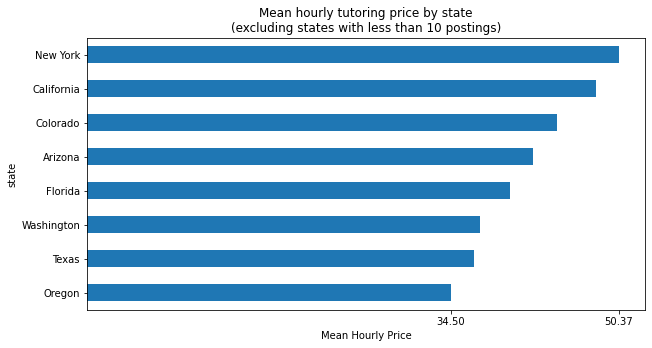

In [6]:
state_counts = df_sql['state'].value_counts().rename('state_counts')

state_counts_df = df_sql.merge(state_counts.to_frame(),
                               left_on='state',
                               right_index=True)

st_cnt_greater_10 = state_counts_df['state_counts']>=10
st_avg_greater_10 = state_counts_df[st_cnt_greater_10].groupby('state')['price'].agg(['mean', 'size'])
st_avg_greater_10.rename(columns={'mean':'mean_price', 'size':'num_postings'}, inplace=True)

fig, ax = plt.subplots(1,1,figsize=(10,5))
#state_counts_df[st_cnt_greater_10]['state'].value_counts().plot(kind='bar', ax=ax);

st_avg_greater_10['mean_price'].sort_values(ascending=True).plot(kind='barh', ax=ax)
ax.set_xticks([st_avg_greater_10['mean_price'].min(), 
               st_avg_greater_10['mean_price'].max()])
ax.set_xlabel('Mean Hourly Price')
plt.title('Mean hourly tutoring price by state\n(excluding states with less than 10 postings)');

## Using SQL

In [7]:
avg_price_by_state = pd.read_sql_query("""SELECT cl.state
                                               , AVG(cl.price) AS mean_price
                                            FROM cl_tutoring AS cl
                                           WHERE cl.date_scraped = '2022-02-03'
                                             AND cl.price IS NOT NULL
                                        GROUP BY cl.state
                                          HAVING COUNT(cl.id) >= 10
                                        ORDER BY 2 DESC;""", con=conn, index_col='state')

/Users/rancher/opt/anaconda3/envs/ox/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


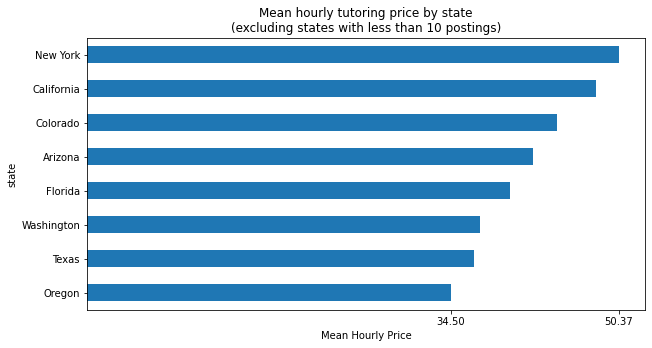

In [8]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
#state_counts_df[st_cnt_greater_10]['state'].value_counts().plot(kind='bar', ax=ax);

avg_price_by_state.sort_values(by='mean_price',ascending=True).plot(kind='barh', ax=ax)
ax.set_xticks([st_avg_greater_10['mean_price'].min(), 
               st_avg_greater_10['mean_price'].max()])
ax.set_xlabel('Mean Hourly Price')
plt.title('Mean hourly tutoring price by state\n(excluding states with less than 10 postings)')
ax.get_legend().remove();

# Which States had the most postings?

## Using Python

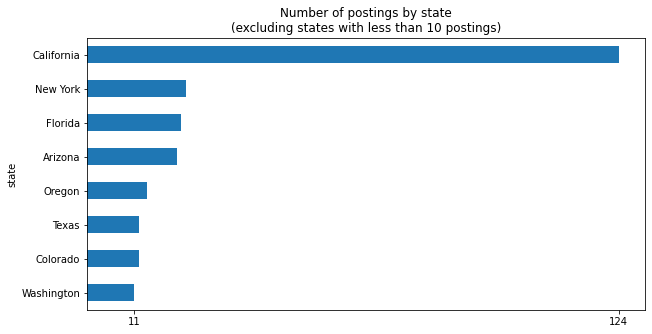

In [9]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
#state_counts_df[st_cnt_greater_10]['state'].value_counts().plot(kind='bar', ax=ax);

st_avg_greater_10['num_postings'].sort_values(ascending=True).plot(kind='barh', ax=ax, )
ax.set_xticks([st_avg_greater_10['num_postings'].min(), st_avg_greater_10['num_postings'].max()])
plt.title('Number of postings by state\n(excluding states with less than 10 postings)');

## Using SQL

In [10]:
post_count_by_state = pd.read_sql_query("""
  SELECT cl.state
       , COUNT(cl.id) AS num_postings
    FROM cl_tutoring AS cl
   WHERE cl.date_scraped = '2022-02-03' AND cl.price IS NOT NULL
GROUP BY cl.state
  HAVING COUNT(cl.id) >= 10
ORDER BY 2 DESC;""", con=conn, index_col='state')

/Users/rancher/opt/anaconda3/envs/ox/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


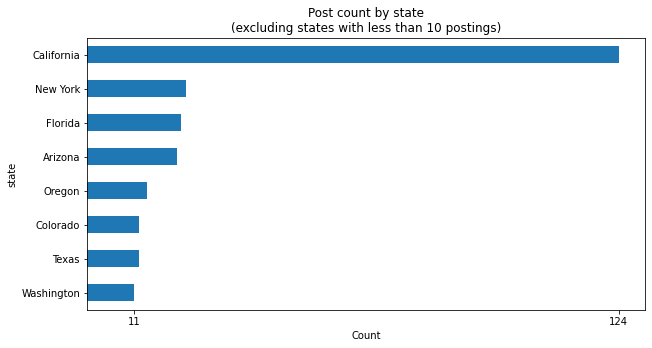

In [11]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
#state_counts_df[st_cnt_greater_10]['state'].value_counts().plot(kind='bar', ax=ax);

post_count_by_state.sort_values(by='num_postings',ascending=True).plot(kind='barh', ax=ax)
ax.set_xticks([post_count_by_state['num_postings'].min(), 
               post_count_by_state['num_postings'].max()])
ax.set_xlabel('Count')
plt.title('Post count by state\n(excluding states with less than 10 postings)')
ax.get_legend().remove();

# Which state sub-regions had the most postings?

## Using Python

In [12]:
groupby_region = df_sql.groupby('region')
mean_and_size_by_region = groupby_region['price'].agg(['mean', 'size'])

mean_and_size_by_region_greater_10 = mean_and_size_by_region[mean_and_size_by_region['size']>=10]

mean_and_size_by_region_greater_10

,mean,size
region,,
losangeles,54.161765,34
newyork,49.176471,17
orangeco,36.764706,17
phoenix,44.250000,16
sfbayarea,57.100000,40


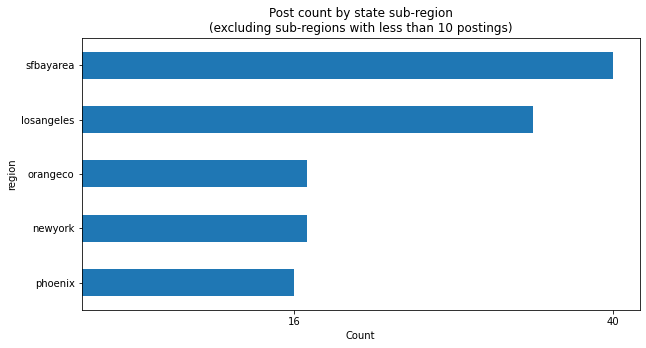

In [13]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

mean_and_size_by_region_greater_10['size'].sort_values().plot(kind='barh', ax=ax)

ax.set_xticks([mean_and_size_by_region_greater_10['size'].min(), 
               mean_and_size_by_region_greater_10['size'].max()])
ax.set_xlabel('Count')
plt.title('Post count by state sub-region\n(excluding sub-regions with less than 10 postings)');

## Using SQL

In [14]:
post_count_by_region = pd.read_sql_query("""
  SELECT cl.region
       , COUNT(cl.id) AS num_postings
    FROM cl_tutoring AS cl
   WHERE cl.date_scraped = '2022-02-03' AND cl.price IS NOT NULL
GROUP BY cl.region
  HAVING COUNT(cl.id) >= 10
ORDER BY 2 DESC;""", con=conn, index_col='region')

/Users/rancher/opt/anaconda3/envs/ox/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [15]:
post_count_by_region

,num_postings
region,
sfbayarea,40
losangeles,34
orangeco,17
newyork,17
phoenix,16


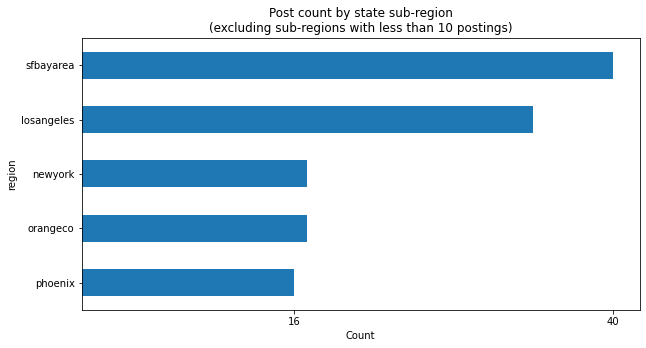

In [16]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
#state_counts_df[st_cnt_greater_10]['state'].value_counts().plot(kind='bar', ax=ax);

post_count_by_region.sort_values(by='num_postings',ascending=True).plot(kind='barh', ax=ax)
ax.set_xticks([post_count_by_region['num_postings'].min(), 
               post_count_by_region['num_postings'].max()])
ax.set_xlabel('Count')
plt.title('Post count by state sub-region\n(excluding sub-regions with less than 10 postings)')
ax.get_legend().remove();

# What is the average hourly price by state sub-region?

## Using Python

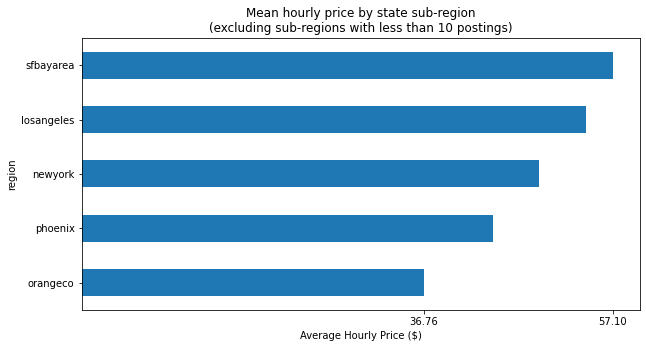

In [17]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

mean_and_size_by_region_greater_10['mean'].sort_values().plot(kind='barh', ax=ax)

ax.set_xticks([mean_and_size_by_region_greater_10['mean'].min(), 
               mean_and_size_by_region_greater_10['mean'].max()])
ax.set_xlabel('Average Hourly Price ($)')
plt.title('Mean hourly price by state sub-region\n(excluding sub-regions with less than 10 postings)');

## Using SQL

In [18]:
mean_price_by_region = pd.read_sql_query("""
  SELECT cl.region
       , AVG(cl.price) AS mean_price
    FROM cl_tutoring AS cl
   WHERE cl.date_scraped = '2022-02-03' AND cl.price IS NOT NULL
GROUP BY cl.region
  HAVING COUNT(cl.id) >= 10
ORDER BY 2 DESC;""", con=conn, index_col='region')

/Users/rancher/opt/anaconda3/envs/ox/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


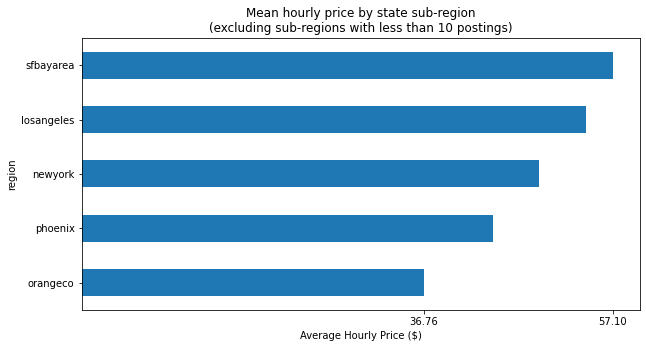

In [19]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

mean_price_by_region['mean_price'].sort_values().plot(kind='barh', ax=ax)

ax.set_xticks([mean_price_by_region['mean_price'].min(), 
               mean_price_by_region['mean_price'].max()])
ax.set_xlabel('Average Hourly Price ($)')
plt.title('Mean hourly price by state sub-region\n(excluding sub-regions with less than 10 postings)');

# What is the mean hourly price per state and number of postings for the ENTIRE dataset?

## Using Python

In [20]:
state_list_greater_10 = st_avg_greater_10.index.to_list()

def state_grouper_by_count(df, ind, col):
    state = df[col].loc[ind]
    if df[col].loc[ind] in state_list_greater_10:
        return state 
    else:
        return 'Other'
states_grpby_count = df_sql.groupby(lambda x: state_grouper_by_count(df_sql, x, 'state'))

In [21]:
mean_price_by_state_w_other = states_grpby_count['price'].agg('mean').sort_values(ascending=True)

post_count_by_state_w_other = states_grpby_count['price'].agg('size').sort_values(ascending=True)

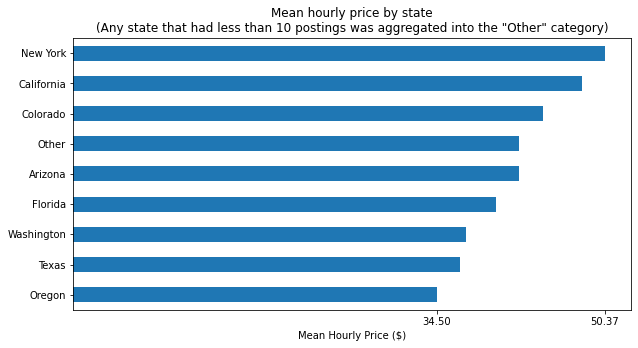

In [22]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
mean_price_by_state_w_other.plot(kind='barh', ax=ax)
ax.set_xticks([mean_price_by_state_w_other.min(), 
               mean_price_by_state_w_other.max()])
ax.set_xlabel('Mean Hourly Price ($)')
plt.title('Mean hourly price by state\n(Any state that had less than 10 postings was aggregated into the "Other" category)');

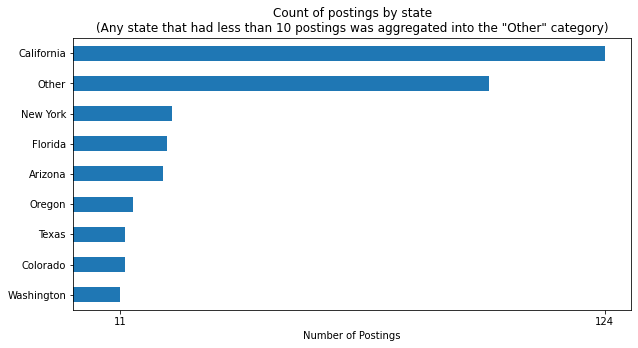

In [23]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
post_count_by_state_w_other.plot(kind='barh', ax=ax)
ax.set_xticks([post_count_by_state_w_other.min(), 
               post_count_by_state_w_other.max()])
ax.set_xlabel('Number of Postings')
plt.title('Count of postings by state\n(Any state that had less than 10 postings was aggregated into the "Other" category)');

## Using SQL

In [24]:
average_price_for_all_states = pd.read_sql_query("""
WITH states_greater_10_posts AS (
  SELECT cl.state
    FROM cl_tutoring AS cl
   WHERE cl.date_scraped = '2022-02-03' AND cl.price IS NOT NULL
GROUP BY cl.state
  HAVING COUNT(cl.id) >= 10
)

  SELECT 'Other' AS state
       , AVG(price) AS mean_price
       , COUNT(*) AS num_posts
    FROM cl_tutoring
   WHERE state NOT IN (SELECT state 
                       FROM states_greater_10_posts)
     AND date_scraped = '2022-02-03'
     AND price IS NOT NULL

   UNION 

  SELECT cl.state
       , AVG(cl.price) AS mean_price
       , COUNT(*) AS num_posts
    FROM cl_tutoring AS cl
   WHERE cl.date_scraped = '2022-02-03' AND cl.price IS NOT NULL
GROUP BY cl.state
  HAVING COUNT(cl.price) >= 10
ORDER BY 2 DESC;""", con=conn, index_col='state')

/Users/rancher/opt/anaconda3/envs/ox/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


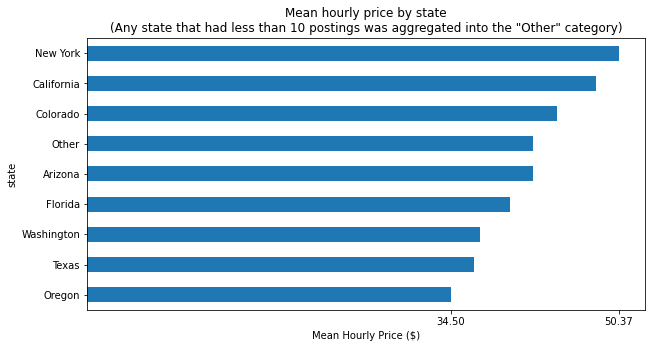

In [25]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
average_price_for_all_states['mean_price'].sort_values().plot(kind='barh', ax=ax)
ax.set_xticks([average_price_for_all_states['mean_price'].min(), 
               average_price_for_all_states['mean_price'].max()])
ax.set_xlabel('Mean Hourly Price ($)')
plt.title('Mean hourly price by state\n(Any state that had less than 10 postings was aggregated into the "Other" category)');

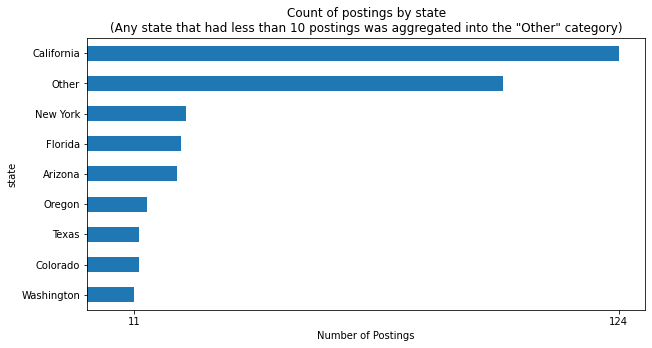

In [26]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
average_price_for_all_states['num_posts'].sort_values().plot(kind='barh', ax=ax)
ax.set_xticks([average_price_for_all_states['num_posts'].min(), 
               average_price_for_all_states['num_posts'].max()])
ax.set_xlabel('Number of Postings')
plt.title('Count of postings by state\n(Any state that had less than 10 postings was aggregated into the "Other" category)');

# What is the mean hourly price by US Census Region?

## Using Python

In [28]:
groupby_us_region = df_sql.groupby('us_region')
mean_and_size_by_us_region = groupby_us_region['price'].agg(['mean', 'size'])

mean_and_size_by_us_region

,mean,size
us_region,,
Midwest,38.181159,23
Northeast,48.981481,45
South,40.931818,66
West,45.013201,202


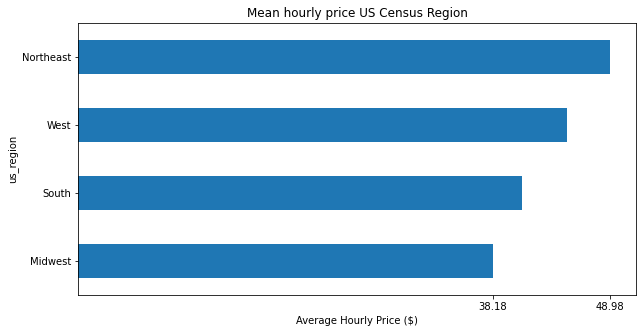

In [30]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
mean_and_size_by_us_region['mean'].sort_values().plot(kind='barh', ax=ax)
ax.set_xticks([mean_and_size_by_us_region['mean'].min(), 
               mean_and_size_by_us_region['mean'].max()])
ax.set_xlabel('Average Hourly Price ($)')
plt.title('Mean hourly price US Census Region');

## Using SQL

In [33]:
mean_and_count_by_us_census_region = pd.read_sql_query("""
WITH cl_tutoring_w_census AS (
   SELECT cl.*, cr.us_region, cr.us_division
     FROM cl_tutoring AS cl
LEFT JOIN us_census_regions AS cr
       ON cl.state = cr.state
    WHERE cl.date_scraped = '2022-02-03'
      AND cl.price IS NOT NULL
  )

   SELECT cltwc.us_region
        , AVG(cltwc.price) AS mean_price
        , COUNT(cltwc.id) AS num_postings
     FROM cl_tutoring_w_census AS cltwc
 GROUP BY cltwc.us_region;
""", con=conn, index_col='us_region')

/Users/rancher/opt/anaconda3/envs/ox/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


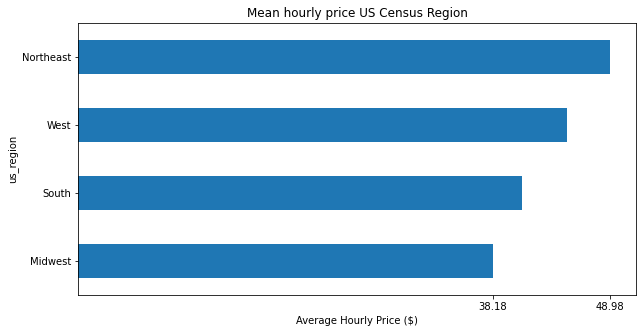

In [34]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
mean_and_count_by_us_census_region['mean_price'].sort_values().plot(kind='barh', ax=ax)
ax.set_xticks([mean_and_count_by_us_census_region['mean_price'].min(), 
               mean_and_count_by_us_census_region['mean_price'].max()])
ax.set_xlabel('Average Hourly Price ($)')
plt.title('Mean hourly price US Census Region');

# What US Census Region had the most postings?

## Using Python

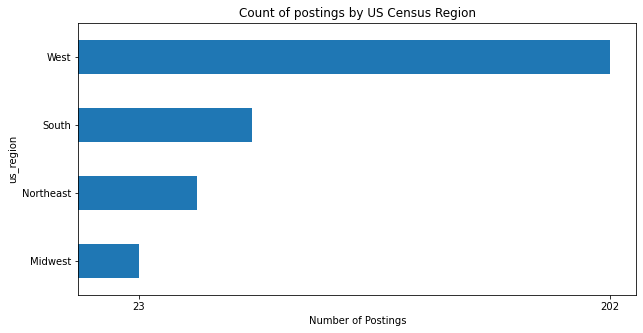

In [31]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
mean_and_size_by_us_region['size'].sort_values().plot(kind='barh', ax=ax)
ax.set_xticks([mean_and_size_by_us_region['size'].min(), 
               mean_and_size_by_us_region['size'].max()])
ax.set_xlabel('Number of Postings')
plt.title('Count of postings by US Census Region');

## Using SQL

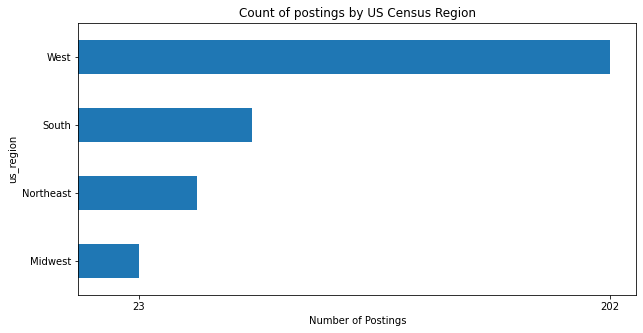

In [35]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
mean_and_count_by_us_census_region['num_postings'].sort_values().plot(kind='barh', ax=ax)
ax.set_xticks([mean_and_count_by_us_census_region['num_postings'].min(), 
               mean_and_count_by_us_census_region['num_postings'].max()])
ax.set_xlabel('Number of Postings')
plt.title('Count of postings by US Census Region');

# What is the mean hourly price by US Census Division?

## Using Python

In [36]:
groupby_us_division = df_sql.groupby('us_division')
mean_and_count_by_us_census_division = groupby_us_division['price'].agg(['mean', 'size'])

mean_and_count_by_us_census_division

,mean,size
us_division,,
East North Central,34.510417,16
East South Central,49.166667,3
Middle Atlantic,49.402778,36
Mountain,41.819728,49
New England,47.296296,9
Pacific,46.035948,153
South Atlantic,42.585106,47
West North Central,46.571429,7
West South Central,34.531250,16


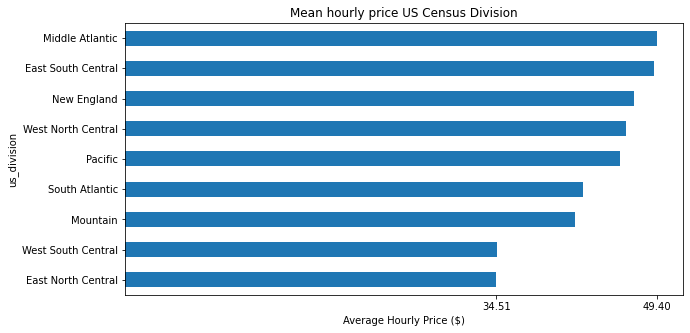

In [37]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
mean_and_count_by_us_census_division['mean'].sort_values().plot(kind='barh', ax=ax)
ax.set_xticks([mean_and_count_by_us_census_division['mean'].min(), 
               mean_and_count_by_us_census_division['mean'].max()])
ax.set_xlabel('Average Hourly Price ($)')
plt.title('Mean hourly price US Census Division');

## Using SQL

In [40]:
mean_and_count_by_us_census_division = pd.read_sql_query("""
WITH cl_tutoring_w_census AS (
   SELECT cl.*, cr.us_region, cr.us_division
     FROM cl_tutoring AS cl
LEFT JOIN us_census_regions AS cr
       ON cl.state = cr.state
    WHERE cl.date_scraped = '2022-02-03'
      AND cl.price IS NOT NULL
  )

   SELECT cltwc.us_division
        , AVG(cltwc.price) AS mean_price
        , COUNT(cltwc.id) AS num_postings
     FROM cl_tutoring_w_census AS cltwc
 GROUP BY cltwc.us_division;
""", con=conn, index_col='us_division')

/Users/rancher/opt/anaconda3/envs/ox/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


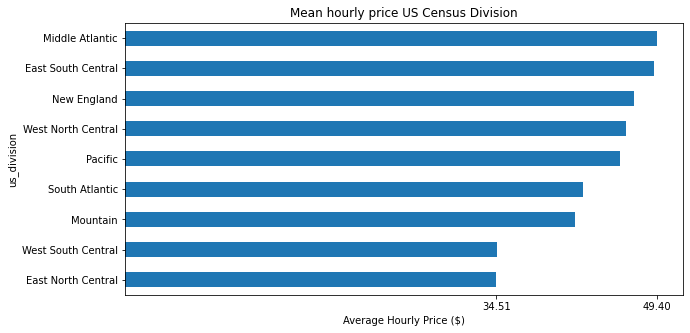

In [41]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
mean_and_count_by_us_census_division['mean_price'].sort_values().plot(kind='barh', ax=ax)
ax.set_xticks([mean_and_count_by_us_census_division['mean_price'].min(), 
               mean_and_count_by_us_census_division['mean_price'].max()])
ax.set_xlabel('Average Hourly Price ($)')
plt.title('Mean hourly price US Census Division');

# What US Census Division had the most postings?

## Using Python

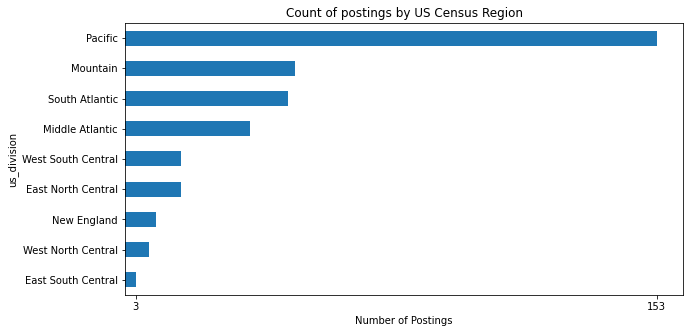

In [38]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
mean_and_count_by_us_census_division['size'].sort_values().plot(kind='barh', ax=ax)
ax.set_xticks([mean_and_count_by_us_census_division['size'].min(), 
               mean_and_count_by_us_census_division['size'].max()])
ax.set_xlabel('Number of Postings')
plt.title('Count of postings by US Census Region');

## Using SQL

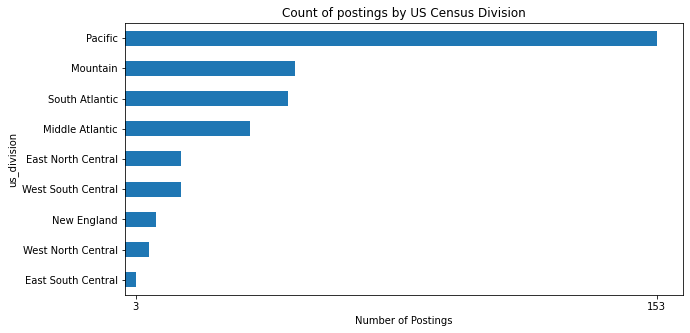

In [42]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
mean_and_count_by_us_census_division['num_postings'].sort_values().plot(kind='barh', ax=ax)
ax.set_xticks([mean_and_count_by_us_census_division['num_postings'].min(), 
               mean_and_count_by_us_census_division['num_postings'].max()])
ax.set_xlabel('Number of Postings')
plt.title('Count of postings by US Census Division');

# Scratch work

In [ ]:
df_sql['region'].value_counts()

In [ ]:
df_sql['subregion'].value_counts()

In [ ]:
df_sql['price'].mean()

In [ ]:
df_sql['price'].median()

In [ ]:
df_sql.groupby(by='region')['price'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)

In [ ]:
df_sql[(df_sql['region']=='los_angeles') & (df_sql['price'] > 60)]['price']

In [ ]:
df_sql[df_sql['region']=='los_angeles'].boxplot(column='price')
plt.scatter(df_sql[df_sql['region']=='los_angeles']['price'])

In [ ]:
sns.boxplot(x='region', y='price', data=df_sql[df_sql['region']=='los_angeles'])
sns.swarmplot(x='region', y='price', data=df_sql[df_sql['region']=='los_angeles'], color='r');